In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [11]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [4]:
import numpy as np
x_train = np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy")


In [36]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self,path):
        self.x_input = np.load(path).astype(np.float32).reshape(-1, 28*28)

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, idx):
        return torch.cuda.FloatTensor(self.x_input[idx])

data_loader = DataLoader(MyDataset("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy"), batch_size=1000, shuffle=True)

In [44]:
import torch
import numpy 
from torch.nn import MSELoss
from torch.optim import Adam

class VAE(torch.nn.Module):
    def __init__(self,dim_latent = 2):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,2*dim_latent),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_latent,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,784),
            torch.nn.Sigmoid()
        )
        self.dim_latent = dim_latent
        self.optim_en = Adam(self.encoder.parameters(),lr=0.002)
        self.optim_de = Adam(self.decoder.parameters(),lr=0.002)
        self.loss_fn = MSELoss()

        self.num_epoch=400
        self.hist_loss = []
        self.hist_model = []

    def forward(self,x):
        x = self.encoder(x).view(-1,2,self.dim_latent)

        self.mu = x[:,0,:]
        self.log_var = x[:,1,:]
        epsilon = torch.randn_like(self.mu)

        sigma = torch.exp(self.log_var/2)

        self.z = self.mu+sigma*epsilon

        de = self.decoder(self.z)
        return de

    def train(self,x_input):
        for epoch in range(1, 401):
            self.optim_en.zero_grad()
            self.optim_de.zero_grad()
            y_pred = self.forward(x_input)
            
            mse_loss = ((y_pred- x_input)**2).sum()
            kl_loss = -0.5*torch.sum(1+self.log_var-self.mu**2 - torch.exp(self.log_var))
            loss = mse_loss+kl_loss
            loss.backward()
            self.optim_de.step()
            self.optim_en.step()
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: loss = {loss.item()} / mse:{mse_loss*1000:.2f} kl:{kl_loss:.2f}")

    def visualize(self):
        pass
        

In [45]:
%%time
x_input = torch.cuda.FloatTensor(x_train).reshape(-1,784)
vae =VAE()
vae.train(x_input)


Epoch 50: loss = 3214954.5 / mse:3211723520.00 kl:3230.88
Epoch 100: loss = 2949714.25 / mse:2868024832.00 kl:81689.62
Epoch 150: loss = 2867065.25 / mse:2768876288.00 kl:98188.98
Epoch 200: loss = 2713992.25 / mse:2556784896.00 kl:157207.27
Epoch 250: loss = 2619593.5 / mse:2438840832.00 kl:180752.69
Epoch 300: loss = 2562270.0 / mse:2369483520.00 kl:192786.47
Epoch 350: loss = 2515766.25 / mse:2312721408.00 kl:203044.80
Epoch 400: loss = 2480565.5 / mse:2270683648.00 kl:209881.62
CPU times: user 13.4 s, sys: 152 ms, total: 13.5 s
Wall time: 13.7 s


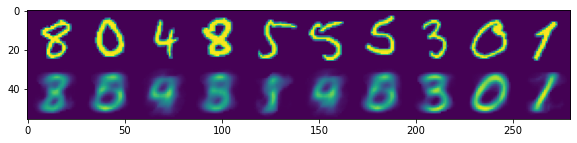

In [46]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 20):
    x_np = np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy")
    x_np = x_np[np.random.choice(x_np.shape[0], n_samples)]
    y_pre = model.forward(torch.cuda.FloatTensor(x_np).flatten(start_dim=1)).detach().cpu().numpy()
    y_samples = y_pre.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)
    x_samples = x_np.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(vae, 10)

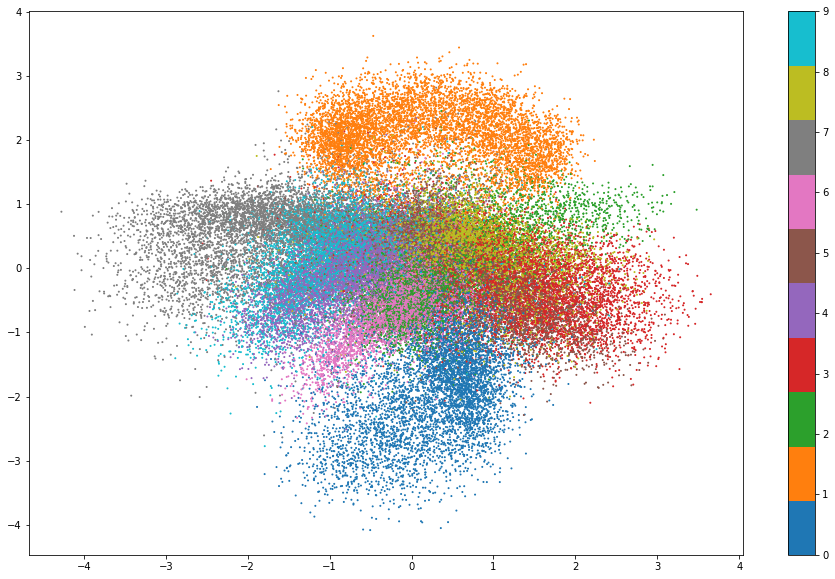

In [47]:
def visualize(model):
    x_input = torch.cuda.FloatTensor(np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy")).flatten(start_dim=1)
    model.forward(x_input)
    z = model.z.detach().cpu().numpy() # (60000, 2)
    y_target = np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_y_train.npy") # 샘플 색 결정

    plt.figure(figsize=(16, 10))
    plt.scatter(z[:,0], z[:,1], c=y_target, cmap="tab10", s = 1)
    plt.colorbar()

visualize(vae)

In [48]:
torch.save(vae.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_vae_trained.pth")

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  193478 KB |    1586 MB |    1201 GB |    1201 GB |
|---------------------------------------------------------------------------|
| Active memory         |  193478 KB |    1586 MB |    1201 GB |    1201 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1636 MB |    1636 MB |    1636 MB |       0 B  |
|---------------------------------------------------------------

In [34]:
import torch
import numpy 
from torch.nn import MSELoss
from torch.optim import Adam

class VAE(torch.nn.Module):
    def __init__(self,dim_latent = 2):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,2*dim_latent),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_latent,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,784),
        )
        self.dim_latent = dim_latent
        self.optim_en = Adam(self.encoder.parameters(),lr=0.02)
        self.optim_de = Adam(self.decoder.parameters(),lr=0.02)
        self.loss_fn = MSELoss()

        self.num_epoch=400
        self.hist_loss = []
        self.hist_model = []

    def forward(self,x):
        x = self.encoder(x).view(-1,2,self.dim_latent)

        self.mu = x[:, 0, :]
        self.sigma = torch.exp(x[:, 1, :])
        self.z = self.mu + self.sigma * torch.randn_like(self.mu)

        de = self.decoder(self.z)
        return de

    def train(self,x_input):
        for epoch in range(1, 10001):
            self.optim_en.zero_grad()
            self.optim_de.zero_grad()
            y_pred = self.forward(x_input)
            
            mse_loss = ((x_input - y_pred)**2).sum()
            kl_loss = (self.sigma**2 + self.mu**2 - torch.log(self.sigma) - 0.5).sum()
            loss = mse_loss + kl_loss

            loss.backward()
            self.optim_de.step()
            self.optim_en.step()
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: loss = {loss.item()}")

    def visualize(self):
        pass
        

In [28]:
%%time

x_input = torch.cuda.FloatTensor(x_train).reshape(-1,784)
vae =VAE()
vae.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_vae_honglab_trained.pth"))


CPU times: user 83.1 ms, sys: 81.5 ms, total: 165 ms
Wall time: 166 ms


<All keys matched successfully>

In [31]:
vae.train(x_input)

Epoch 50: loss = 2846301.5
Epoch 100: loss = 2726929.25
Epoch 150: loss = 2659163.0
Epoch 200: loss = 2633230.0
Epoch 250: loss = 2617670.75
Epoch 300: loss = 2607966.5
Epoch 350: loss = 2599411.25
Epoch 400: loss = 2593194.75
Epoch 450: loss = 2609850.25
Epoch 500: loss = 2584718.5
Epoch 550: loss = 2590342.75
Epoch 600: loss = 2581179.25
Epoch 650: loss = 2577751.5
Epoch 700: loss = 2576075.25
Epoch 750: loss = 2576044.5
Epoch 800: loss = 2574061.75
Epoch 850: loss = 2572030.0
Epoch 900: loss = 2580556.25
Epoch 950: loss = 2597250.0
Epoch 1000: loss = 2577954.0
Epoch 1050: loss = 2570743.25
Epoch 1100: loss = 2571156.25
Epoch 1150: loss = 2569289.0
Epoch 1200: loss = 2576840.5
Epoch 1250: loss = 2579645.75
Epoch 1300: loss = 2566846.25
Epoch 1350: loss = 2574823.5
Epoch 1400: loss = 2567144.75
Epoch 1450: loss = 2565783.75
Epoch 1500: loss = 2569194.0
Epoch 1550: loss = 2568757.75
Epoch 1600: loss = 2567415.0
Epoch 1650: loss = 2566978.0
Epoch 1700: loss = 2565995.5
Epoch 1750: loss 

In [9]:
vae.train(x_input)

Epoch 50: loss = 2565078.75
Epoch 100: loss = 2566713.0
Epoch 150: loss = 2560980.75
Epoch 200: loss = 2561524.25
Epoch 250: loss = 2562599.25
Epoch 300: loss = 2562692.5
Epoch 350: loss = 2562122.0
Epoch 400: loss = 2567870.75
Epoch 450: loss = 2564829.25
Epoch 500: loss = 2565083.75
Epoch 550: loss = 2562450.5
Epoch 600: loss = 2561318.25
Epoch 650: loss = 2560453.0
Epoch 700: loss = 2560389.0
Epoch 750: loss = 2587452.25
Epoch 800: loss = 2573699.5
Epoch 850: loss = 2569703.25
Epoch 900: loss = 2566304.25
Epoch 950: loss = 2562711.5
Epoch 1000: loss = 2563551.25
Epoch 1050: loss = 2563815.0
Epoch 1100: loss = 2564124.25
Epoch 1150: loss = 2563710.25
Epoch 1200: loss = 2560880.0
Epoch 1250: loss = 2561433.5
Epoch 1300: loss = 2583983.5
Epoch 1350: loss = 2560345.25
Epoch 1400: loss = 2560716.5
Epoch 1450: loss = 2562840.5
Epoch 1500: loss = 2566464.5
Epoch 1550: loss = 2573004.5
Epoch 1600: loss = 2582670.25
Epoch 1650: loss = 2561896.75
Epoch 1700: loss = 2565400.0
Epoch 1750: loss 

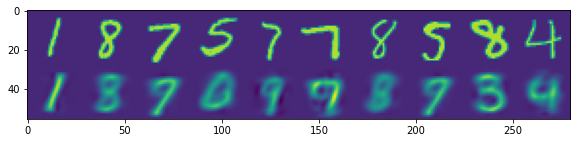

In [32]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 20):
    x_np = np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy")
    x_np = x_np[np.random.choice(x_np.shape[0], n_samples)]
    y_pre = model.forward(torch.cuda.FloatTensor(x_np).flatten(start_dim=1)).detach().cpu().numpy()
    y_samples = y_pre.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)
    x_samples = x_np.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(vae, 10)

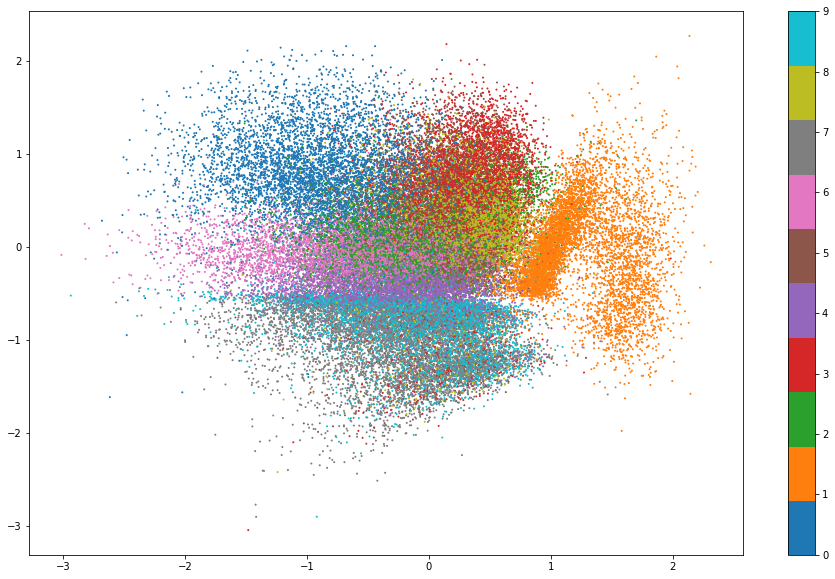

In [33]:
def visualize(model):
    x_input = torch.cuda.FloatTensor(np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_x_train.npy")).flatten(start_dim=1)
    model.forward(x_input)
    z = model.z.detach().cpu().numpy() # (60000, 2)
    y_target = np.load("./mount/My Drive/Colab Notebooks/GDLgon/MNIST_y_train.npy") # 샘플 색 결정

    plt.figure(figsize=(16, 10))
    plt.scatter(z[:,0], z[:,1], c=y_target, cmap="tab10", s = 1)
    plt.colorbar()

visualize(vae)

In [12]:
torch.save(vae.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_vae_honglab_trained.pth")